# PROJETO INTEGRADO CDIA5 - GRUPO 2

## Coletando dados de uma API

### Visão geral

Esse caderno tem como objetivo coletar os dados da API publica CIViC (Clinical Interpretation of variants in cancer) e transforma-los em dataframes.

### Objetivo do código

Acessar a API CIViC e coletar os dados fornecidos.

In [1]:
#Importações
import requests
import json
import pandas as pd

## API's

Existem quatro tipos de informações diferentes que podem ser acessadas, cada um com seu próprio endereço na API. Por padrão, recebemos uma informação por vez. No entanto, estamos mudando o valor "count" para recebermos mais informações em uma unica chamada.

URL's para coletar os valores*

Evidences: "https://civicdb.org/api/evidence_items".

Variant: "https://civicdb.org/api/variants".

Gene: "https://civicdb.org/api/genes".

Para cada uma das APIs, faremos uma solicitação GET, sendo que cada uma delas possui um retorno diferente. A fim de garantir que a solicitação de coleta tenha sido aceita, verificaremos o "status_code". Os códigos mais comuns incluem:

200: tudo funcionou conforme o esperado e a validação dos dados foi realizada com sucesso.

400: ocorreram problemas durante a autenticação.

401: este erro ocorre quando há algum problema na requisição.

500: ocorreu algum erro interno no servidor.

Além disso, manteremos um padrão de 10.000 para o retorno.

In [2]:
#URL da API
Evidences = requests.get('https://civicdb.org/api/evidence_items?count=10000')
Variant = requests.get('https://civicdb.org/api/variants?count=10000')
Gene = requests.get('https://civicdb.org/api/genes?count=10000')

In [3]:
#Codigo de status 
print(f"Status_code de Evidences: {Evidences.status_code}")
print(f"Status_code de Variant: {Variant.status_code}")
print(f"Status_code de Gene: {Gene.status_code}")

Status_code de Evidences: 200
Status_code de Variant: 200
Status_code de Gene: 200


Json.loads() É um método usado para decodificar uma string JSON em um objeto Python. O objeto Python resultante pode ser uma lista, um dicionário, um valor de string, um número, um valor booleano ou None. A função .content é usada para retornar o conteúdo de uma resposta HTTP em formato de bytes.

Converteremos o conteúdo da resposta HTTP, que é originalmente uma string no formato JSON, para um dicionário Python utilizando a função .loads.

In [4]:
#Json.load: Pega um objeto em arquivo e retorna o objeto json;
#contente: Retorna o contéudo da resposta em dicionario.
Evidences_dict=json.loads(Evidences.content)
Variant_dict=json.loads(Variant.content)
Gene_dict=json.loads(Gene.content)

Utilizando o método pd.DataFrame iremos converter o dicionário Python em um dataframe pandas com os dados retornados pela API.

In [5]:
#Pega apenas uma das chaves que a URL retorna e a transforma em um dataframe.
df_evidences=pd.DataFrame(Evidences_dict["records"])
df_variant=pd.DataFrame(Variant_dict["records"])
df_gene=pd.DataFrame(Gene_dict["records"])

In [6]:
#Salva o dataframe criado.
df_evidences.to_csv('Evidence.csv', index=False)
df_variant.to_csv('Variants.csv', index=False)
df_gene.to_csv('Genes.csv', index=False)

Em virtude das informações citadas acima, entendemos que esse código busca um grande conjunto de dados em 3 URL's diferentes, Gene, Evidences, Variants e os transforma em dataset para que possam ser usados posteriormente.

## Junção CSV's CIViC

Infelizmente, os dados que a API oferece não são suficientes para a realização da nossa análise. Por isso, usaremos dados fornecidos pelo CIViC. Assim como na API, os arquivos CSV também estão separados e precisam ser mesclados. Para isso, iremos utilizar a função "merge".

Abaixo, definiremos os arquivos que iremos utilizar.

In [7]:
#Definiçao dos arquivos que serão utilizados
df_Variant = pd.read_csv('01-Apr-2022-VariantSummaries.csv')
df_Evidences = pd.read_csv('01-Apr-2022-ClinicalEvidenceSummaries.csv')
df_Gene = pd.read_csv('01-Apr-2022-GeneSummaries.csv')

Possuímos três DataFrames diferentes: df_Variant, que possui 1533 linhas e 33 colunas, df_evidences, que possui 3897 linhas e 42 colunas e df_gene com 477 linhas e 7 colunas.

Antes de podermos realizar o merge, precisamos fazer um pequeno tratamento nos dados fornecidos. Inicialmente, iremos trocar o nome de duas colunas, que possue o mesmo valor e significado, porém com nome diferente em outros df's.

In [8]:
#Trocando o nome da coluna name para gene.
df_Variant.rename(columns={'summary': 'variant_summary'}, inplace = True)
df_Gene.rename(columns={'name': 'gene'}, inplace = True)

Também precisamos apagar algumas colunas, pois elas não se encontram em nenhum outro df, e por conta disso, a mesclagem se torna um problema. Essas colunas serão excluídas, mas nenhum dado importante será perdido.

In [9]:
#Apagando colunas
df_Variant = df_Variant.drop(['assertion_ids', 'is_flagged'],axis=1)
df_Gene = df_Gene.drop(['gene_civic_url', 'last_review_date', 'is_flagged'],axis=1)

Com os df's tratados, podemos realizar o merge. Inicialmente, iremos juntar o df_Variant tratado e o df_Evidences. Assim, criaremos um df nomeado CIViC que possui a junção de todos os registros dos dois conjuntos de dados originais.

Para que essa mesclagem funcione, usaremos como chave a coluna 'variant_id'.

Para que nossos dados não fiquem poluídos e que não precisemos ter um trabalho extra excluindo colunas repetidas que serão geradas com o merge, pois nosso conjunto de dados possuem colunas com o mesmo nome, iremos definir o parâmetro "suffixes" como uma tupla vazia e uma tupla com o sufixo "_y", o que garantirá que não haverá colunas duplicadas após a junção.

Após a junção, usaremos o método "filter" para selecionar apenas as colunas que possuem o sufixo "_y" no nome e usaremos o método "drop" para removê-las.

In [10]:
#Merge entre Civic e df_Variant
civic = pd.merge(df_Evidences, df_Variant,  left_on='variant_id', right_on='variant_id', how='left', suffixes=('','_y'))
civic.drop(civic.filter(regex='_y$').columns, axis=1, inplace=True)

Em seguida juntaremos ao conjunto total ao df_Gene. Usaremos as colunas "gene" como chave de junção e passaremos o mesmo parâmetro "suffixes" para apagar colunas duplicadas.

In [11]:
#Merge entre Civic e df_gene
civic = pd.merge(civic, df_Gene,  left_on='gene', right_on='gene', how='left', suffixes=('','_y'))
civic.drop(civic.filter(regex='_y$').columns, axis=1, inplace=True)

Agora, com o dataframe pronto, realizaremos o último tratamento dessa etapa. Aqui, apagaremos colunas sem valor para nossa análise, como URLs e a última edição ("last_review_date"), colunas com valores nulos em todos os dataframes.

In [12]:
#Removendo colunas
civic = civic.drop(['gene_civic_url', 'Unnamed: 32', 'Unnamed: 31', 'Unnamed: 29',
                    'Unnamed: 30', 'assertion_civic_urls', 'variant_civic_url', 
                    'evidence_civic_url', 'last_review_date', 'asco_abstract_id',
                    'nct_ids', 'chromosome2', 'start2', 'stop2', 'representative_transcript2',
                    'variant_groups'],axis=1)
civic.head()

,gene,entrez_id,variant,disease,doid,phenotypes,drugs,drug_interaction_type,evidence_type,evidence_direction,...,variant_summary,variant_origin,is_flagged,variant_types,hgvs_expressions,civic_variant_evidence_score,allele_registry_id,clinvar_ids,variant_aliases,description
0,JAK2,3717,V617F,Lymphoid Leukemia,1037.0,NaN,NaN,NaN,Diagnostic,Supports,...,JAK2 V617F is a highly recurrent mutation in m...,Somatic,False,"missense_variant,gain_of_function_variant","NC_000009.11:g.5073770G>T,NM_004972.3:c.1849G>...",83.0,CA124183,14662,"VAL617PHE,RS77375493",JAK2 is a kinase that is misregulated or mutat...
1,PDGFRA,5156,D842V,Gastrointestinal Stromal Tumor,9253.0,NaN,NaN,NaN,Diagnostic,Supports,...,PDGFRA D842 mutations are characterized broadl...,Somatic,False,missense_variant,"NM_006206.4:c.2525A>T,NP_006197.1:p.Asp842Val,...",100.5,CA123194,13543,"ASP842VAL,RS121908585","Commonly mutated in GI tract tumors, PDGFR fam..."
2,DNMT3A,1788,R882,Acute Myeloid Leukemia,9119.0,NaN,NaN,NaN,Diagnostic,Supports,...,DNMT3A R882 mutations are associated with cyto...,Somatic,False,missense_variant,NaN,510.0,NaN,"375882,375883,375884,375879,375880,375881","R693,ARG882,ARG693",DNMT3A is one of several epigenetic modifiers ...
3,DNMT3A,1788,R882,Acute Myeloid Leukemia,9119.0,NaN,NaN,NaN,Diagnostic,Supports,...,DNMT3A R882 mutations are associated with cyto...,Somatic,False,missense_variant,NaN,510.0,NaN,"375882,375883,375884,375879,375880,375881","R693,ARG882,ARG693",DNMT3A is one of several epigenetic modifiers ...
4,JAK2,3717,V617F,Chronic Myeloid Leukemia,8552.0,NaN,NaN,NaN,Diagnostic,Supports,...,JAK2 V617F is a highly recurrent mutation in m...,Somatic,False,"missense_variant,gain_of_function_variant","NC_000009.11:g.5073770G>T,NM_004972.3:c.1849G>...",83.0,CA124183,14662,"VAL617PHE,RS77375493",JAK2 is a kinase that is misregulated or mutat...


In [13]:
civic.columns

Index(['gene', 'entrez_id', 'variant', 'disease', 'doid', 'phenotypes',
       'drugs', 'drug_interaction_type', 'evidence_type', 'evidence_direction',
       'evidence_level', 'clinical_significance', 'evidence_statement',
       'citation_id', 'source_type', 'citation', 'rating', 'evidence_status',
       'evidence_id', 'variant_id', 'gene_id', 'chromosome', 'start', 'stop',
       'reference_bases', 'variant_bases', 'representative_transcript',
       'ensembl_version', 'reference_build', 'variant_summary',
       'variant_origin', 'is_flagged', 'variant_types', 'hgvs_expressions',
       'civic_variant_evidence_score', 'allele_registry_id', 'clinvar_ids',
       'variant_aliases', 'description'],
      dtype='object')

Diante disso, podemos ver que nosso código consiste na leitura de três arquivos csv fornecidos pelo proprio CIViC, e na sua mesclagem em um dataframe final chamado civic, tambem possuimos alguns tratamentos sendo realizados nos dados, como a exclusão de colunas, a renomeação de colunas e a remoçao de valores duplicados. Ao final o Dataframe civic é salvo em um arquivo csv para ser utilizado posteriormente.

In [14]:
#Salvando o df Civic como um csv
civic.to_csv('civic.csv', index=False)

# Análise Descritiva

In [15]:
#Consultando numero de colunas e linhas.
print(f'O Conjunto de dados possui {civic.shape[0]} linhas e {civic.shape[1]} colunas.')

O Conjunto de dados possui 3897 linhas e 39 colunas.


### Descrição das colunas:

- **Gene:** Nome do gene que sofreu a multação;
- **entrez_id:** ID do gene;
- **variant:** Descrição do tipo de variante;
- **disease:** Doença específica ou subtipo de doença associada;
- **doid:** ID de disease;
- **phenotypes:** Fenótipo específico associado a declaração de evidências;
- **drugs:** Droga usada durante o tratamento;
- **evidence_type:** Categoria da ação clínica/relevância implicada pelo evento. (Predictive - Evidência pertencente ao efeito de um perfil molecular na resposta terapêutica. Diagnostic - Evidência relativa ao impacto de um perfil molecular no diagnóstico do paciente. Prognostic - Evidência pertencente ao impacto de um perfil molecular na progressão da doença, gravidade ou sobrevida do paciente; Predisposing - A evidência refere-se ao papel de um perfil molecular da linhagem germinativa em conferir suscetibilidade à doença (incluindo avaliações de patogenicidade); Oncogenic - A evidência refere-se ao envolvimento de um perfil molecular somático na patogênese do tumor; Functional - A evidência refere-se ao impacto de um perfil molecular na função do produto gênico(por exemplo, proteína));
- **evidence_direction:** Um indicador de se a declaração de evidência apóia ou refuta a importância de um evento. (Supports ou Does not support);
- **clinical_significance:** O impacto do perfil molecular (uma ou mais variantes) para tipos de evidências preditivas, prognósticas, diagnósticas, oncogênicas ou funcionais. (Sensitivity/Response - Associada a uma resposta clínica ou pré-clínica ao tratamento; Reduced Sensitivity - A resposta ao tratamento é menor do que a observada em outros contextos de tratamento; Resistance - Associada á resistência clínica ou pré-clínica ao tratamento; Adverse Response - Associada a uma resposta adversa ao tratamento medicamentoso; N/A - A variante não informa o interpretação clínica; Positive - Associada ao diagnóstico de doença ou subtipo; Negative - Associada á ausência de doença ou subtipo; Better outcome - Demonstra resultado clínico melhor do que o esperado; Poor outcome - Demonstra resultado clínico pior do que o esperado; Pathogenic - As evidências podem contribuir para uma interpretação de patogênico/benigno no nível de afirmação; Proteção - A presença de um perfil molecular germinativo reduz a chance de cancêr;
- **variant_id:** ID da variante.
- **gene_id:** ID do gene (Exibido automaticamente pela interface CIVIC.)
- **is_flagged:** Se o paciente deu algum sinal de que possuia cancêr antes do inicio do tratamento. (Fácil detecção);
- **drug_interaction_type:** Se a droga usada durante o tratamento teve que ser substituida ou combinada/complementada;
- **evidence_level:** Descreve a robustez do tipo de estudo que suporta o item de evidência; (A - Associação validad, B - Evidência clínica, C - Estudo de caso, D - Evidência pré-clínica, E - Associação inferencial);
- **evidence_statement:** Detalhes de tipos específicos de declarações de evidências: Uma reiteração do tipo de evidência, perfil molecular (variante), gene e doença;
- **citation_id:** ID de citation
- **source_type:** Tipo de fonte e ID, vincula o item de evidência à publicação original que suporta as reivindicações de evidência.
- **citation:** Publicação onde o evento foi descrito/explorado gerado automaticamente a partir do ID PudMed fornecido pelo curador e links para a página interna da publicaçãi CIVIC mostrando todos os itens de evidência da publicação;
- **rating:** Discernir rapidamente o quão bem a evidência derivada do artigo ou fonte suporta uma determinada declaração de evidência, um sistema de classificação de cinco estrelas é usado, (5 -Evidência fortes e bem fundamentadas de um laboratório ou periódico com reputação acadêmica respeitada. Os experimentos são bem controlados e os resultados são limpos e reprodutíveis em várias réplicas. Evidências confirmadas por métodos independentes. O estudo é estatisticamente bem alimentado, 4 - Evidência forte e bem suportada. As experiências são bem controladas e os resultados são convincentes. Quaisquer discrepâncias dos resultados esperados são bem explicadas e não são preocupantes, 3 - As evidências são convincentes, mas não apoiadas por uma variedade de experimentos. Podem ser projetos de menor escala ou novos resultados sem muitos experimentos de acompanhamento. As discrepâncias dos resultados esperados são explicadas e não são preocupantes, 2 - As evidências não são bem apoiadas por dados experimentais e poucos dados de acompanhamento estão disponíveis. A publicação é de um periódico de baixo impacto acadêmico. Os experimentos podem carecer de controles adequados, ter tamanho de amostra pequeno ou não serem estatisticamente convincentes, 1 - A alegação não é bem apoiada por evidências experimentais. Os resultados não são reprodutíveis ou têm um tamanho de amostra muito pequeno. Nenhum acompanhamento é feito para validar novas reivindicações.);
- **evidence_status:** Se o experimento apoio ou não apoia a variante usada;
- **evidence_id:** ID da evidencia;
- **chromosome:** Nome do cromossomo no qual ocorre a variante;
- **stat:** Posições inicial da variante (coordenada do genoma baseada em 1).
- **stop:** Posições final da variante. A partida deve ser menor ou igual à parada.
- **reference_bases:** A base nucleotídica do alelo de referência e variante (por exemplo, 'C', 'A');
- **variant_bases:** A base nucleotídica do alelo de referência e variante (por exemplo, 'C', 'A');
- **representative_transcript:** ID da transcrição do conjunto e número da versão para uma transcrição conhecida do gene que contém a variante;
- **ensembl_version:** Versão de compilação da anotação Ensembl.
- **reference_build:** Versão de montagem de referência humana NCBI ou GRC.
- **variant_summary:** Descrição curta da variante; (Explicação do gene e do cancêr);
- **variant_origin:** Como a variante começou. (Somatic - Essas variantes surgem pontualmente em algumas células do corpo e não são passadas de pai para filho, causa mais comum de câncer e resultam de danos acumulados no DNA ao longo da vida, Rare Germline- Tipo menos comum de cancêr, está presente nas células germinativas(gametas:espermatozoides e óvulos) e é passada diretamente de pai pra fiho no momento da concepção);
- **variant_types:** Os tipos de variantes são usados para classificar variantes por termos de Ontologia de Sequência. (missense_variant - Uma variante de sequência, que muda uma ou mais bases, resultando em uma sequência de aminoácidos diferente, mas onde o comprimento é preservado, stop_gained - Uma variante de sequência em que pelo menos uma base de um códon é alterada, resultando em um códon de parada prematuro, levando a um polipeptídeo encurtado, protein_altering_variant - Uma sequência_variante que é prevista para alterar a proteína codificada na sequência de codificação, frameshift_truncamento - Uma variante de deslocamento de quadro que faz com que o quadro de leitura translacional seja encurtado em relação ao recurso de referência, inframe_deletion - Uma variante não sinônima de quadro que exclui bases da sequência de codificação, inframe_insertion - Uma variante não sinônima do quadro que insere bases na sequência de codificação, splice_acceptor_variant - Uma variante que afeta o local aceitador de splicing de RNA (ou seja, a montante ou a montante/3prime de uma borda de exon), splice_donor_variant - Uma variante que afeta o local receptor do doador de RNA (ou seja, a jusante/5prime de uma borda de exon), gene_variant - Uma variante de sequência em que a estrutura do gene é alterada, transcrição_variante - Uma variante de sequência que altera a estrutura da transcrição, loss_of_function_variant - Uma variante de sequência pela qual o produto do gene diminuiu ou aboliu a função, gain_of_function_variant - Uma variante de sequência pela qual uma função nova ou aprimorada é conferida ao produto gênico);
- **hgvs_expressions:** Strings HGVS definidas pelo usuário seguindo a nomenclatura HGVS que representam esta Variante no nível de DNA, RNA ou proteína;
- **civic_variant_evidence_score:** 
- **allele_registry_id:** Identificador de registro de alelo (id de CA) vinculado à página de registro de alelo ClinGen correspondente. Este link é gerado automaticamente usando as coordenadas primárias selecionadas (cromossomo, início, parada, base de referência, base variante).
- **clinvar_ids:** ID ClinVar definido pelo usuário referenciando esta variante que será vinculada diretamente ao ClinVar. Um valor de “Nenhum especificado” indica que a variante não foi avaliada para uma ID ClinVar. Um valor de “None Found” indica que foi feita uma tentativa de encontrar uma entrada ClinVar correspondente, mas não existe nenhuma. Um valor de “N/A” indica que um registro ClinVar não é aplicável à variante
- **variant_aliases:** Nomes alternativos para esta variante. Podem ser versões mais detalhadas (por exemplo, 'Val600Glu'), IDs dbSNP ou nomenclatura alternativa usada na literatura.
- **description:** Descrição do gene e cancêr que será tratado.

In [16]:
#Verificando o tipo dos dados.
civic.dtypes

gene                             object
entrez_id                         int64
variant                          object
disease                          object
doid                            float64
phenotypes                       object
drugs                            object
drug_interaction_type            object
evidence_type                    object
evidence_direction               object
evidence_level                   object
clinical_significance            object
evidence_statement               object
citation_id                       int64
source_type                      object
citation                         object
rating                          float64
evidence_status                  object
evidence_id                       int64
variant_id                        int64
gene_id                           int64
chromosome                       object
start                           float64
stop                            float64
reference_bases                  object


A maior parte dos nossos dados está no formato "object", o que indica que antes do treinamento será necessário um tratamento para transformá-los em valores numéricos, tambem possuimos valores como "bool", "int64" e "float64"

In [17]:
#Verificando valores nulo
civic.isnull().sum()

gene                               0
entrez_id                          0
variant                            0
disease                           23
doid                              32
phenotypes                      3389
drugs                           1448
drug_interaction_type           3278
evidence_type                      0
evidence_direction               179
evidence_level                     0
clinical_significance            222
evidence_statement                 0
citation_id                        0
source_type                        0
citation                           0
rating                            68
evidence_status                    0
evidence_id                        0
variant_id                         0
gene_id                            0
chromosome                       435
start                            436
stop                             436
reference_bases                 2000
variant_bases                   2055
representative_transcript        466
e

In [18]:
#Consultando se há dados duplicados
civic.nunique()

gene                             332
entrez_id                        332
variant                         1184
disease                          237
doid                             233
phenotypes                       162
drugs                            607
drug_interaction_type              3
evidence_type                      6
evidence_direction                 2
evidence_level                     5
clinical_significance             15
evidence_statement              3675
citation_id                     1705
source_type                        2
citation                        1695
rating                             5
evidence_status                    1
evidence_id                     3897
variant_id                      1533
gene_id                          332
chromosome                        23
start                            983
stop                             988
reference_bases                   54
variant_bases                     42
representative_transcript        333
e

Ao consultar a quantidade de dados duplicados em nossa base, foi constatado que há diversos valores repetidos. Isso pode ser explicado pelo fato de que várias pessoas podem apresentar o mesmo tipo de câncer em um determinado gene, além de serem tratadas com a mesma droga, entre outras situações que podem gerar informações similares.

**Bibliografia:**

https://docs.civicdb.org/en/latest/api.html#v1-api-deprecated https://civic.readthedocs.io/en/latest/model/variants/overview.html https://civic.readthedocs.io/en/latest/model/assertions/overview.html https://civic.readthedocs.io/en/latest/model/evidence.html https://civic.readthedocs.io/en/latest/model/genes.html https://civic.readthedocs.io/en/latest/model/evidence/type.html#evidence-type https://civic.readthedocs.io/en/latest/model/evidence/significance.html#evidence-significance

# Análise Exploratória

In [19]:
#bibliotecas necessárias para os gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

### Análise Gráfica Exploratória das Principais Variáveis

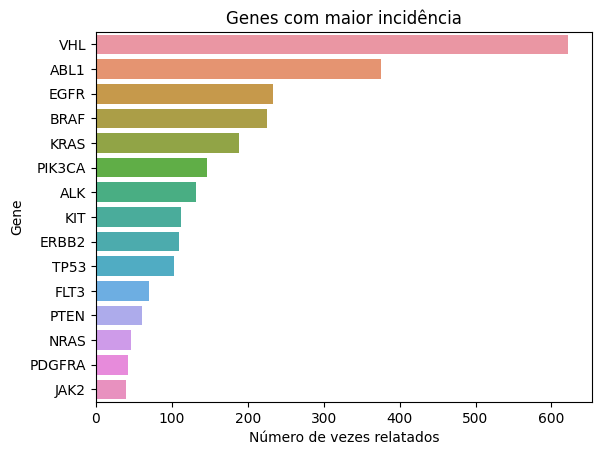

In [20]:
#gráfico de genes com maior incidência
sns.barplot(x = civic['gene'].value_counts()[:15],
            y = civic['gene'].value_counts()[:15].index)
plt.title("Genes com maior incidência")
plt.xlabel("Número de vezes relatados")
plt.ylabel("Gene")
plt.show()

Esse gráfico tem como objetivo mostrar os 15 primeiros genes com maior incidência, dessa forma podemos ver qual gene sofre mutação com mais frequência. 

OBS: O gene VHL resposavel pelo câncer renal secundário está em primeiro lugar na lista enquanto o gene TP53 responsavel pelo câncer de pele esta em 10° lugar e é o mais frequente no Brasil enquanto o de pulmão que é o mais comum no mundo e está em 21° lugar.

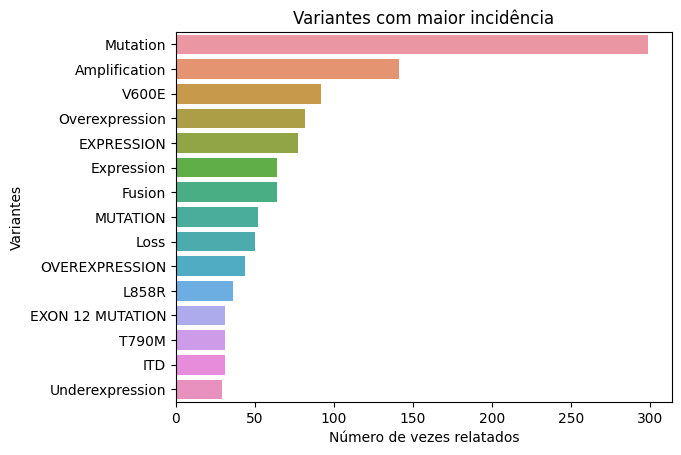

In [21]:
#gráfico de variantes com maior incidência
sns.barplot(x = civic['variant'].value_counts()[:15],
            y = civic['variant'].value_counts()[:15].index)
plt.title("Variantes com maior incidência")
plt.xlabel("Número de vezes relatados")
plt.ylabel("Variantes")
plt.show()

Nossa base de dados esta repleta de tipos de variants, nesse gráfico aptamos por mostrar apenas as 15° com maior incidência para uma melhor visualização.

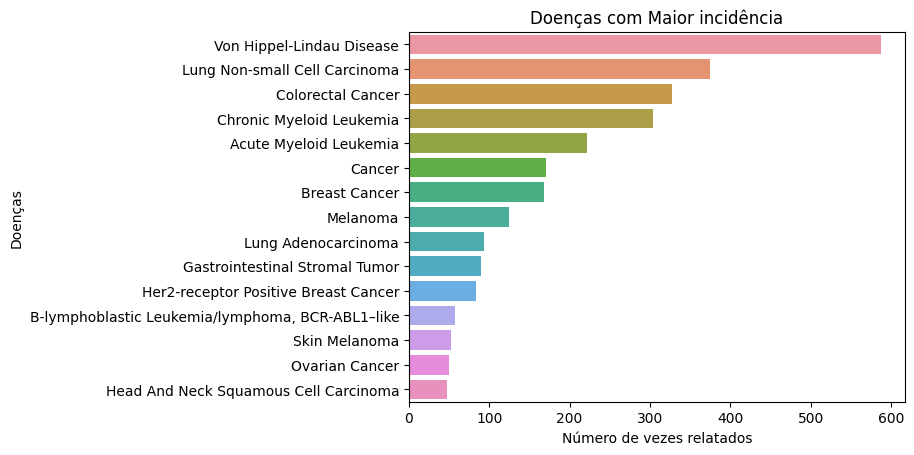

In [22]:

#gráfico de doenças com maior incidência
sns.barplot(x = civic['disease'].value_counts()[:15],
            y = civic['disease'].value_counts()[:15].index)
plt.title("Doenças com Maior incidência")
plt.xlabel("Número de vezes relatados")
plt.ylabel("Doenças")
plt.show()


Assim como o gráfico de Variant optamos por mostrar apenas 15 itens pra melhor visualização. 

OBS: Podemos observar, por exemplo, que a doença Von Hippel-Lindau Disease esta diretamente ligada ao gene VHL, por isso ambos esta em primeiro lugar e com maior incidência.

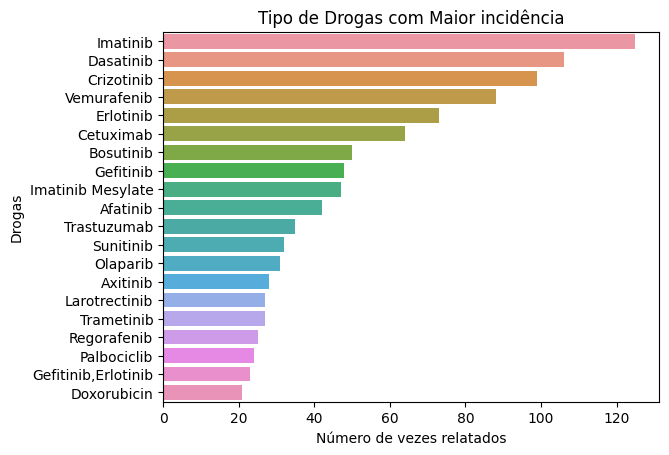

In [23]:
#gráfico de drogas com maior incidência
sns.barplot(x = civic['drugs'].value_counts()[:20],
            y = civic['drugs'].value_counts()[:20].index)
plt.title("Tipo de Drogas com Maior incidência")
plt.xlabel("Número de vezes relatados")
plt.ylabel("Drogas")
plt.show()

Em nossa base observamos que varias drogas foram usadas durante os tratamentos, nesse gráfico plotamos apenas 20 das drogas mais usadas.

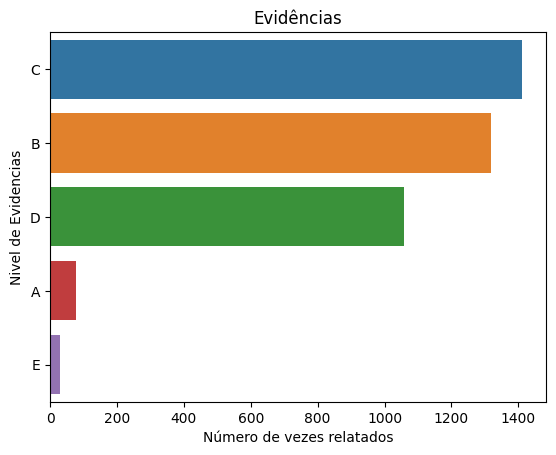

In [24]:
#gráfico de evidências
sns.barplot(x = civic['evidence_level'].value_counts()[:5],
            y = civic['evidence_level'].value_counts()[:5].index)
plt.title("Evidências")
plt.xlabel("Número de vezes relatados")
plt.ylabel("Nivel de Evidencias")
plt.show()

Aqui visualizarmos a robustez do estudo suportado pela evidência, podemos ver que "C - Estudo de caso" possui a maior incidência com 200 itens a mais e "E - Associanção inferencial" possui a menor quantidade com menos de 200 itens.

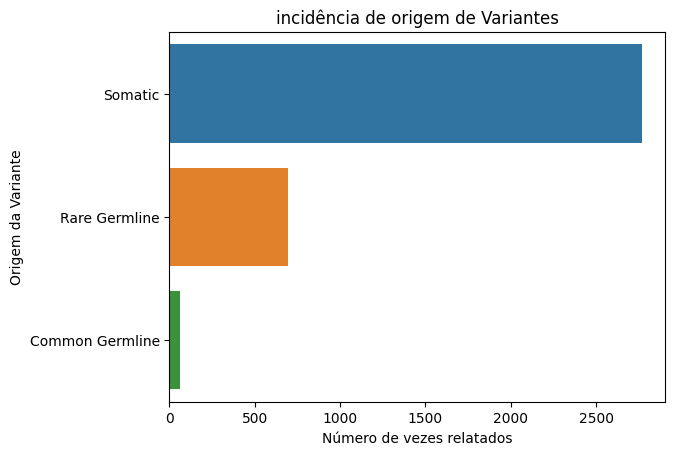

In [25]:
#Gráfico de origem das variantes
sns.barplot(x = civic['variant_origin'].value_counts()[:3],
            y = civic['variant_origin'].value_counts()[:3].index)
plt.title("incidência de origem de Variantes")
plt.xlabel("Número de vezes relatados")
plt.ylabel("Origem da Variante")
plt.show()

Como a variante começou ?

Nesse gráfico visualizamos que a maior parte das doenças cancerigenas começaram como somaticas, ou seja que surgem pontualmente em alguma célula do corpo e a menor parte como common gemline, ou seja presente nas células germinativas, cancer que pode ser transferido de pais para filhos.

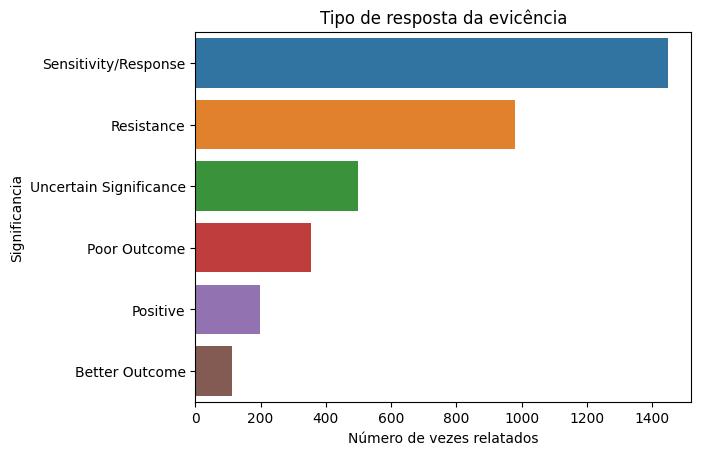

In [26]:
#Gráfico de resposta da evidência
sns.barplot(x = civic['clinical_significance'].value_counts()[:6],
            y = civic['clinical_significance'].value_counts()[:6].index)
plt.title("Tipo de resposta da evicência")
plt.xlabel("Número de vezes relatados")
plt.ylabel("Significancia")
plt.show()

Como o perfil molecular reagiu ao tratamento ?

A maior parte teve uma resposta "Sensitivity/Responde", significa que o organismo respondeu ao estímulo, isso não quer dizer que a resposta foi possitiva ou negativa, apenas indica que ouve uma minima resposta. A menor parte "Better Outcome", ou seja, Demosntra resultado clínico melhor do que o esperado.

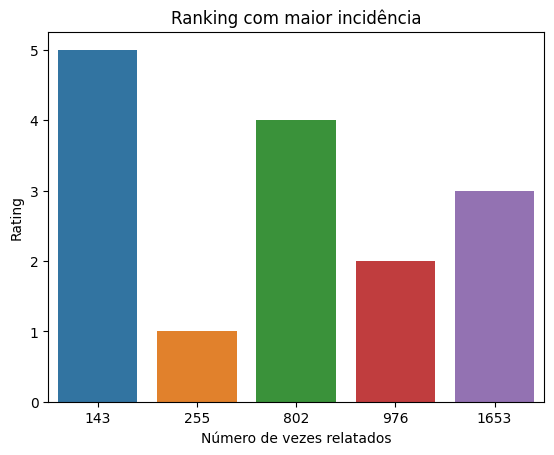

In [27]:
#Gráfico das incidências
sns.barplot(x = civic['rating'].value_counts()[:5],
            y = civic['rating'].value_counts()[:5].index)
plt.title("Ranking com maior incidência")
plt.xlabel("Número de vezes relatados")
plt.ylabel("Rating")
plt.show()

Esse gráfico serve para nos mostrar rapidamente o quão bem foi o tratamento escolhido. A maior parte dos tratamentos receberam 5 "estrelas", forma como foram avaliados, tendo eviências fortes e bem fundamentadas com resultados limpos. A menor parte recebeu 1 "estrela", significando que a alegação não foi bem sucedida, os resultados são sujos e não reprodutíveis ou têm um tamanho de amostra muito pequeno.

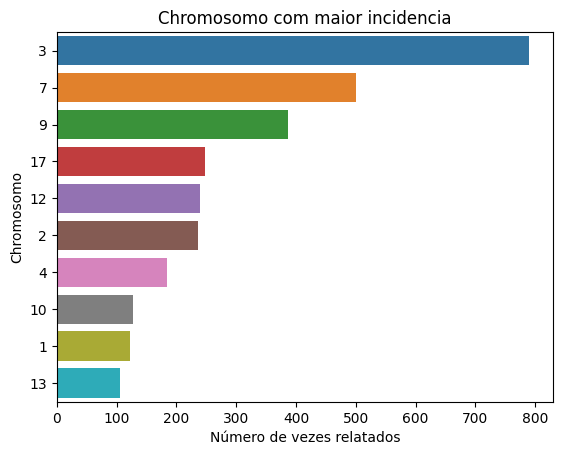

In [28]:
#Gráfico dos chromossomos
sns.barplot(x = civic['chromosome'].value_counts()[:10],
            y = civic['chromosome'].value_counts()[:10].index)
plt.title("Chromosomo com maior incidencia")
plt.xlabel("Número de vezes relatados")
plt.ylabel("Chromosomo")
plt.show()

Esse gráfico é interessante pois nele podemos observar em quais cromossomos ouve a maior incidencia de mudanças, por exemplo o chromossomo 3. primeiro nesse gráfico, é onde ocorre a mutação que causa a doença VHL ou doença de Von Hippel-Lindau, os dois primeiros casos em gene e disease.

### Comparação de outras colunas com disease usando px

In [29]:
# agrupa os dados pela combinação de "variant_origin" e "disease" e soma a quantidade de ocorrências de cada combinação
grouped_origin_df = civic.groupby(['variant_origin', 'disease']).size().reset_index(name='count')
# ordena os dados pela quantidade de ocorrências em ordem decrescente
sorted_origin_df = grouped_origin_df.sort_values('count', ascending=False)
# seleciona as informações mais relevantes
top_origin_df = sorted_origin_df.head(30)

# conta a frequência dos valores em cada coluna
var_counts = civic['disease'].value_counts().reset_index()
origin_counts = civic['variant_origin'].value_counts().reset_index()
# renomeia as colunas
origin_counts.columns = ['variant_origin', 'count']
var_counts.columns = ['disease', 'count']

# cria o gráfico de dispersão
fig = px.scatter(top_origin_df, x='disease', y='variant_origin', size='count',title='Identificando a origen da doença',
            color_discrete_sequence=px.colors.qualitative.Pastel,
            template='plotly_dark')
# mostra o gráfico
fig.show()


Com esse gráfico interativo podemos observar 15 itens de disease comparados a coluna variant_origin, podemos ver que a maioria dos cânceres são somaticos enquando 584 são geminativo raro e 14 germinativo comum.

In [30]:
# agrupa os dados pela combinação de "gene" e "disease" e soma a quantidade de ocorrências de cada combinação
grouped_genes_df = civic.groupby(['disease', 'gene']).size().reset_index(name='count')
# ordena os dados pela quantidade de ocorrências em ordem decrescente
sorted_genes_df = grouped_genes_df.sort_values('count', ascending=False)
# seleciona as informações mais relevantes
top_genes_df = sorted_genes_df.head(10)

# Cria o gráfico de barras
fig = px.bar(top_genes_df, x='gene', y='count', color='disease', 
             title='Frequência dos disease por gene (Top 10)',
             color_discrete_sequence=px.colors.qualitative.Pastel)#, #template='plotly_dark')
# Personaliza os rótulos do eixo x e y
fig.update_xaxes(title='gene')
fig.update_yaxes(title='Frequência')
# Mostra o gráfico
fig.show()

Com que frequencia disease é associada a gene ? VHL e Von Hippeç-Lindau tem um interação de quase 600, enquanto FLT3 e Acute Myloid Leukemia tem pouco menos de 100 intereções.

In [31]:
# agrupa os dados pela combinação de "disease" e "variant" e soma a quantidade de ocorrências de cada combinação
grouped_variant_df = civic.groupby(['disease', 'variant']).size().reset_index(name='count')
# ordena os dados pela quantidade de ocorrências em ordem decrescente
sorted_variant_df = grouped_variant_df.sort_values('count', ascending=False)
# seleciona as informações mais relevantes
top_variant_df = sorted_variant_df.head(10)

# Cria o gráfico de barras
fig = px.bar(top_variant_df, x='variant', y='count', color='disease', 
             title='Frequência dos disease por variant (Top 8)',
             color_discrete_sequence=px.colors.qualitative.Pastel)#, #template='plotly_dark')
# Personaliza os rótulos do eixo x e y
fig.update_xaxes(title='variant')
fig.update_yaxes(title='Frequência')
# Mostra o gráfico
fig.show()

Cada doença possui sua variant, quais as maiores interações ? Por exemplo: Mutation se relaciona com 3 diseases, colorectal cancer com uma contagem de 41 aparições, acute myeloid leukemia com 37 aparições e lung non-small cell com 36 aparições

In [32]:
# agrupa os dados pela combinação de "disease" e "drugs" e soma a quantidade de ocorrências de cada combinação
grouped_drugs_df = civic.groupby(['disease', 'drugs']).size().reset_index(name='count')
# ordena os dados pela quantidade de ocorrências em ordem decrescente
sorted_drugs_df = grouped_drugs_df.sort_values('count', ascending=False)
# seleciona as informações mais relevantes
top_drugs_df = sorted_drugs_df.head(10)

# Cria o gráfico de barras
fig = px.bar(top_drugs_df, x='drugs', y='count', color='disease', 
             title='Frequência dos disease por drugs (Top 10)',
             color_discrete_sequence=px.colors.qualitative.Pastel)#, #template='plotly_dark')
# Personaliza os rótulos do eixo x e y
fig.update_xaxes(title='drugs')
fig.update_yaxes(title='Frequência')
# Mostra o gráfico
fig.show()

Para cada câncer uma ou mais drogas são usadas em seus tratamentos, quais as melhores interações ?

Ex: Chronic Myeloid Leukemia tem uma grande interação com dasatinib, imatinib, bosutinib, imatinib mesylate, ou seja, esse tipo de câncer pode ser tratado com todas essas drogas mas a que mais é usada é a imatinib.

In [33]:
# agrupa os dados pela combinação de "disease" e "evidence_type" e soma a quantidade de ocorrências de cada combinação
grouped_evidence_type_df = civic.groupby(['disease', 'evidence_type']).size().reset_index(name='count')
# ordena os dados pela quantidade de ocorrências em ordem decrescente
sorted_evidence_type_df = grouped_evidence_type_df.sort_values('count', ascending=False)
# seleciona as informações mais relevantes
top_evidence_type_df = sorted_evidence_type_df.head(10)

# Cria o gráfico de barras
fig = px.bar(top_evidence_type_df, x='evidence_type', y='count', color='disease', 
             title='Frequência dos disease por tipo de evidencia (Top 10)',
             color_discrete_sequence=px.colors.qualitative.Pastel)#, #template='plotly_dark')
# Personaliza os rótulos do eixo x e y
fig.update_xaxes(title='evidence_type')
fig.update_yaxes(title='Frequência')
# Mostra o gráfico
fig.show()

Com esse gráfico visualizamos os tipos cancerigenos e como normalmente eles são diagnosticados. Ex: Von Hippel é na maior parte das vezes uma predisposição enquanto Lung Non-Small é um preditivo e Acute Myeloid Leukemia normalmente é um prognostico.

In [34]:
# agrupa os dados pela combinação de "disease" e "clinical_significance" e soma a quantidade de ocorrências de cada combinação
grouped_clinical_significance_type_df = civic.groupby(['disease', 'clinical_significance']).size().reset_index(name='count')
# ordena os dados pela quantidade de ocorrências em ordem decrescente
sorted_clinical_significance_type_df = grouped_clinical_significance_type_df.sort_values('count', ascending=False)
# seleciona as informações mais relevantes
top_clinical_significance_type_df = sorted_clinical_significance_type_df.head(10)

# Cria o gráfico de barras
fig = px.bar(top_clinical_significance_type_df, x='clinical_significance', y='count', color='disease', 
             title='Frequência dos disease por significancia clinica (Top 10)',
             color_discrete_sequence=px.colors.qualitative.Pastel)#, #template='plotly_dark')
# Personaliza os rótulos do eixo x e y
fig.update_xaxes(title='clinical_significance')
fig.update_yaxes(title='Frequência')
# Mostra o gráfico
fig.show()

Como os tipos cancerigenos responderam ao tratamento ? Von Hippel tende a responder com significancia incerta, enquanto melanoma tente a ter uma resposta sensitiva e o proprio cancer tente a ser resistente.

In [35]:
# agrupa os dados pela combinação de "disease" e "chromosome" e soma a quantidade de ocorrências de cada combinação
grouped_chromosome_type_df = civic.groupby(['disease', 'chromosome']).size().reset_index(name='count')
# ordena os dados pela quantidade de ocorrências em ordem decrescente
sorted_chromosome_type_df = grouped_chromosome_type_df.sort_values('count', ascending=False)
# seleciona as informações mais relevantes
top_chromosome_type_df = sorted_chromosome_type_df.head(10)

# Cria o gráfico de barras
fig = px.bar(top_chromosome_type_df, x='chromosome', y='count', color='disease', 
             title='Frequência dos disease por chromosome (Top 10)',
             color_discrete_sequence=px.colors.qualitative.Pastel)#, #template='plotly_dark')
# Personaliza os rótulos do eixo x e y
fig.update_xaxes(title='chromosome')
fig.update_yaxes(title='Frequência')
# Mostra o gráfico
fig.show()


Os tipos cancerigenos realmente tendem a atacar apenas um gene como padrão ? Melanoma ataca o gene 7 com incidencia de 7 itens, cartinoma ataca o gene 7 tambem mas com uma incidência de 134 itens e o Von Hippel ? Bom, ele ataca o gene 3 com uma incidência de 548 itens.

In [36]:
# agrupa os dados pela combinação de "disease" e "rating" e soma a quantidade de ocorrências de cada combinação
grouped_rating_type_df = civic.groupby(['disease', 'rating']).size().reset_index(name='count')
# ordena os dados pela quantidade de ocorrências em ordem decrescente
sorted_rating_type_df = grouped_rating_type_df.sort_values('count', ascending=False)
# seleciona zzas informações mais relevantes
top_rating_type_df = sorted_rating_type_df.head(10)

# conta a frequência dos valores em cada coluna
var_counts = civic['variant_origin'].value_counts().reset_index()
gene_counts = civic['disease'].value_counts().reset_index()
# renomeia as colunas
gene_counts.columns = ['disease', 'count']
var_counts.columns = ['gene', 'count']

# cria o gráfico de dispersão
fig = px.scatter(top_genes_df, x='gene', y='disease', size='count',title='Identificando a doença do gene',
            color_discrete_sequence=px.colors.qualitative.Pastel,
            template='plotly_dark')
# mostra o gráfico
fig.show()

In [37]:
# Cria o gráfico de barras
fig = px.bar(top_rating_type_df, x='rating', y='count', color='disease', 
             title='Frequência dos disease por rating (Top 10)',
             color_discrete_sequence=px.colors.qualitative.Pastel)#, #template='plotly_dark')
# Personaliza os rótulos do eixo x e y
fig.update_xaxes(title='rating')
fig.update_yaxes(title='Frequência')
# Mostra o gráfico
fig.show()

Nem sempre o tratamento que funciona pra funciona pra todos, afinal cada pessoa é uma pessoa, por isso nesse gráfico visualizamos que o ranking pode variar dependendo da doença. Ex: Von Hippel recebeu entre 2 e 3 estrelas enquanto o carcinoma recebeu entre 2, 3 e 4 estrelas.

#### Transformando em número

In [38]:
#Transformando os dados não númericos em númericos.
df = civic[['gene', 'disease', 'variant', 'clinical_significance', 'variant_origin', 'evidence_level', 'drugs']].apply(lambda x: pd.factorize(x)[0])

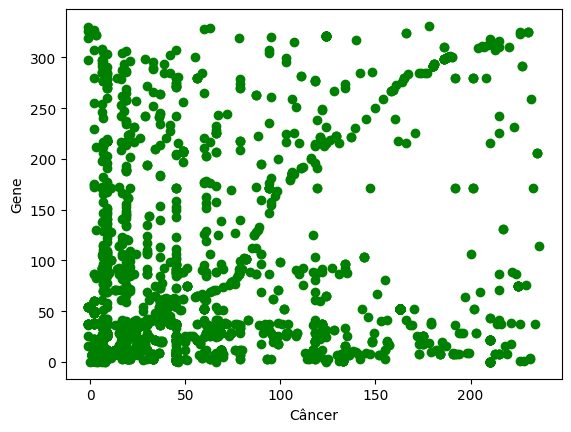

In [39]:
#Gráfico de dispersão (scattler plot)
# Pontos do Gráfico nazz côr verde (c = 'g')
plt.scatter(df['disease'], df['gene'], c='g')
plt.xlabel("Câncer")
plt.ylabel("Gene")
plt.show()

Usamos o scattler plot para observaro compartamento entre duas variáveis e sua relação, podemos ver que perto de 0 existe um grande aglomerado, pois essa são as váriais que mais aparencem em nossos dados.

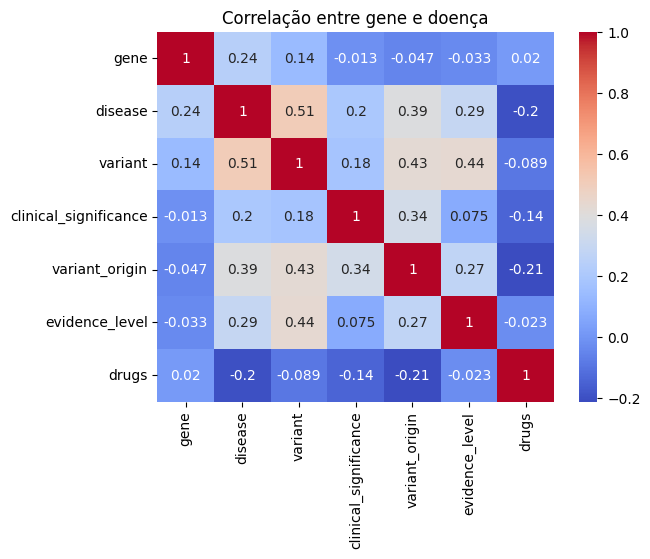

In [40]:
# Calcule a matriz de correlação
correlation_matrix = df.corr()
# Crie o heatmap para visualizar a correlação
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlação entre gene e doença")
plt.show()

Por fim uma matriz de correlação entre as variaveis mais usadas durante esse caderno, os valores próximos de 1 representam uma correlação positiva forte entre as variaveis.
Quando mais proximo de -1 mais forte é a correlação negativa entre duas variaveis.
Se o valor se aproxima de 0 indica que não há uma correlação linear forte.

# Banco de Dados

## Criando um banco de dados

Para o banco de dados, utilizamos o PostgreSQL, criando 3 tabelas, genes, variantes e evidencias. A tabela genes contém os genes que foram analisados, a tabela variantes contém as variantes encontradas e a tabela evidencias contém as evidências encontradas para cada variante.

<img src= "https://raw.githubusercontent.com/perolatai/projeto_CDIA_CIVIC/main/database/civic_erdpng.png">

database backup: <https://github.com/perolatai/projeto_CDIA_CIVIC/blob/main/database/ifaxtmtq.sql.lzo>

-cd "$FILE_NAME" | psql "$DATABASE_NAME"

```python
CREATE TABLE genes
(
    entrez_id INTEGER PRIMARY KEY,
    gene VARCHAR(255),
    description TEXT
);

CREATE TABLE variantes
(
    variant_id INTEGER PRIMARY KEY,
    variant VARCHAR(255),
    summary TEXT,
    start VARCHAR(255),
    stop VARCHAR(255),
    reference_bases VARCHAR(255),
    variant_bases VARCHAR(255),
    representative_transcript VARCHAR(255),
    ensembl_version FLOAT,
    reference_build VARCHAR(255),
    variant_types VARCHAR(255),
    hgvs_expressions VARCHAR(255),
    civic_variant_evidence_score FLOAT,
    allele_registry_id VARCHAR(255),
    clinvar_ids VARCHAR(255),
    variant_aliases VARCHAR(255)
);

CREATE TABLE evidencias
(
    evidence_id INTEGER PRIMARY KEY,
    entrez_id INTEGER,
    disease VARCHAR(255),
    doid FLOAT,
    phenotypes VARCHAR(255),
    drugs VARCHAR(255),
    drug_interaction_type VARCHAR(255),
    evidence_type VARCHAR(255),
    evidence_direction VARCHAR(255),
    evidence_level VARCHAR(255),
    clinical_significance VARCHAR(255),
    evidence_statement TEXT,
    citation_id INTEGER,
    source_type VARCHAR(255),
    citation VARCHAR(255),
    rating FLOAT,
    evidence_status VARCHAR(255),
    variant_id INTEGER,
    chromosome VARCHAR(255),
    variant_origin VARCHAR(255),
    is_flagged BOOLEAN,
    FOREIGN KEY (entrez_id) REFERENCES genes(entrez_id),
    FOREIGN KEY (variant_id) REFERENCES variantes(variant_id)
);
```

A tabela evidencias possui uma chave estrangeira para a tabela variantes, que é a variante_id e uma chave estrangeira para a tabela genes, que é a gene_id, possibilitando a ligação entre as tabelas.

## Inserindo dados

Ao extrairmosos dados da API, utilizamos os arquivos para inserir os dados em nosso banco de dados, atraves de um script em python.

```python
def insert_dataframe_into_mysql(df, table_name, connection):
    cursor = connection.cursor()
    placeholders = ', '.join(['%s'] * len(df.columns))
    columns = ', '.join(df.columns)
    sql = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"
    for _, row in df.iterrows():
        row = pd.concat([pd.Series([0]), row])
        row = row.iloc[1:]
        values = tuple(row.fillna('None'))
        cursor.execute(sql, values)
    connection.commit()


insert_dataframe_into_mysql(df_Gene, 'genes', conn)
insert_dataframe_into_mysql(df_Variant, 'variantes', conn)
insert_dataframe_into_mysql(df_Evidences, 'evidencias', conn)
```

## Disponibilizando os dados

Para que o grupo tenha acesso a todo momento aos dados, disponibilizamos um banco de dados na nuvem, através do site [https://www.elephantsql.com/](https://www.elephantsql.com/), que utilizam o PostgreSQL como banco de dados.

Para acessarmos os dados, utilizamos o seguitne comando:

```python
conn = psycopg2.connect(
    database=database,
    host=host,
    user=user,
    password=password,
    port=port)
```

# API

No nosso trabalho, a função da API é extrair todas as informações do banco de dados CIViC, feito com base numa planilha de mesmo nome, documentando várias informações sobre pacientes com câncer.

Os dados estão divididos em três tabelas: Genes, Evidências e Variantes.

```python
from flask import Flask, make_response, jsonify, request
```

O Flask traz o comandos GET, POST, PUT e DELETE, utilizados para interagir com bancos de dados. Assim, conseguimos utilizar também a sintaxe do SQL para fazer as requisições na nossa base.   
O MySQL.connector liga a API ao banco de dados, bastando fornecer as credenciais criadas pelo gerente do database.   
O Settings é um arquivo .py com as credenciais citadas acima.
```python
conn = psycopg2.connect(
    database=database,
    host=host,
    user=user,
    password=password,
    port=port)

app = Flask(__name__)
app.config['JSON_SORT_KEYS'] = False

cursor = conn.cursor()
```

Colocamos o Flask na variável 'app' e importamos o cursor para poder "navegar" pelo banco de dados.

```python

@app.route('/genes', methods=['GET'])
def get_genes():
    cursor.execute('SELECT * FROM genes')
    lista_genes = cursor.fetchall()

    genes = list()
    for gene in lista_genes:
        genes.append(
            {
                'id':gene[0],
                'gene':gene[1],
                'descrição':gene[2]
            }
        )

    return make_response(
        jsonify(
            message ='Genes:',
            data = genes
        )
    )
```

Os comandos do Flask para definir a rota (/genes) e o método (GET) sempre começam com @.   
Depois fizemos uma função para extrair tudo da tabela GENES, separar o rótulo das colunas e depois aplicá-los nos dados para torná-los mais fáceis de entender. Nessa junção final, utilizamos o **jsonify**.

O mesmo foi feito com as duas outras tabelas, EVIDENCIAS e VARIÁVEIS. O código é o mesmo, mudando apenas as váriaveis e a quantidade de rótulos extraídos, pois as tabelas têm números diferentes de colunas. De qualquer forma, segue o código:

```python
@app.route('/evidencias', methods=['GET'])
def get_evidencias():
    cursor.execute('SELECT * FROM evidencias')
    lista_evidencias = cursor.fetchall()

    # Adicionando os rótulos das colunas;
    evidencias = list()
    for evidencia in lista_evidencias:
        evidencias.append(
            {
                'evidence_id': evidencia[0],
                'entrez_id': evidencia[1],
                'disease': evidencia[2],
                'doid': evidencia[3],
                'phenotypes': evidencia[4],
                'drugs': evidencia[5],
                'drug_interaction_type': evidencia[6],
                'evidence_type': evidencia[7],
                'evidence_direction': evidencia[8],
                'evidence_level': evidencia[9],
                'clinical_significance': evidencia[10],
                'evidence_statement': evidencia[11],
                'citation_id': evidencia[12],
                'source_type': evidencia[13],
                'citation': evidencia[14],
                'rating': evidencia[15],
                'evidence_status': evidencia[16],
                'variant_id': evidencia[17],
                'chromosome': evidencia[18],
                'variant_origin': evidencia[19],
                'is_flagged': evidencia[20]
            }
        )

    return make_response(
        jsonify(
            message ='Evidencias',
            data = evidencias
        )
    )
```

```python
@app.route('/variantes', methods=['GET'])
def get_variantes():
    cursor.execute('SELECT * FROM variantes')
    lista_variantes = cursor.fetchall()

    # Adicionando os rótulos das colunas;
    variantes = list()
    for variante in lista_variantes:
        variantes.append(
            {
                'variant_id':variante[0],
                'variant':variante[1],
                'summary':variante[2],
                'start':variante[3],
                'stop':variante[4],
                'reference_bases':variante[5],
                'variant_bases':variante[6],
                'representative_transcript':variante[7],
                'ensembl_version':variante[8],
                'reference_build':variante[9],
                'variant_types':variante[10],
                'hgvs_expressions':variante[11],
                'civic_variant_evidence_score':variante[12],
                'allele_registry_id':variante[13],
                'clinvar_ids':variante[14],
                'variant_aliases':variante[15]
            }
        )

    return make_response(
        jsonify(
            message ='Variantes:',
            data = variantes
        )
    )
```

Por fim, rodamos a API com um comando do Flask:

```python
if __name__ == "__main__":
    app.run()
```

# Modelo Preditivo

Vamos utilizar a biblioteca PyTorch para o modelo de rede neural.

Com o PyTorch, podemos facilmente criar modelos de redes neurais, definir a função de perda, otimizar os pesos do modelo usando um otimizador, e iterar sobre seus dados de treinamento para ajustar o modelo. PyTorch é uma escolha popular devido à sua facilidade de uso e flexibilidade.

A implementação do modelo foi baseada na documentação oficial do PyTorch que possui uma seção de tutoriais com exemplos práticos e passo a passo detalhado.

https://learn.microsoft.com/pt-br/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model

In [41]:
#importações necessárias para o modelo preditivo
import torch 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F 
import numpy as np 
import torch.optim as optim 
from torch.optim import Adam 
import warnings
warnings.filterwarnings("ignore")

Iremos excluir dados que causarão ruídos no nosso treinamento como colunas que representam o gene mas com códigos diferentes e até citações que ocorreram em algum projeto ou artigo.

Também definiremos a nossa variável alvo que é a coluna 'evidence_type', nela temos as categorias de ações que queremos prever.

In [42]:
#separando X e y
y = civic[['evidence_type']]

# cria a lista para deletar colunas que não servem para o modelo:
toDrop = ['entrez_id', 'evidence_type', 'gene_id', 'evidence_level', 'citation_id', 'source_type', 'citation', 
          'evidence_id', 'representative_transcript','ensembl_version', 'allele_registry_id']

#cria a função para deletar as colunas:
def deletaColuna(dataframe):
    for coluna in toDrop:
        del dataframe[coluna]

#chama a função:
deletaColuna(civic)

#chama o fatorize para transformar as colunas categóricas em número:
X = civic.apply(lambda x: pd.factorize(x)[0])

#converte para número as features:
labels = {'Predictive':0, 'Predisposing':1, 'Prognostic':2, 'Diagnostic':3, 'Oncogenic':4, 'Functional':5} 

#adiciona os numeros para as features categóricas:
y['evidence_type_num'] = y['evidence_type']   
y.evidence_type_num = [labels[item] for item in y.evidence_type_num]

#output: pega a ultima coluna do Y  
output = y.loc[:, 'evidence_type_num'] 

In [43]:
#Converte o dado de Input e o Output para tensor e criar o dataset de Tensor:
input = torch.Tensor(X.to_numpy())      # cria o tensot do tipo torch.float32 
print('\nInput format: ', input.shape, input.dtype)  
output = torch.tensor(output.to_numpy())        # cria o tensor do tipo torch.int64  
print('Output format: ', output.shape, output.dtype)
data = TensorDataset(input, output) 


Input format:  torch.Size([3897, 28]) torch.float32
Output format:  torch.Size([3897]) torch.int64


In [44]:
#separa em treino, validação e test usando random_split
train_batch_size = 5 #quantidade de passagens pelo conjunto
number_rows = len(input)    
test_split = int(number_rows*0.3)  
validate_split = int(number_rows*0.2) 
train_split = number_rows - test_split - validate_split     
train_set, validate_set, test_set = random_split( data, [train_split, validate_split, test_split])  

In [45]:
#Cria o Dataloader para ler o dado com tamanho batch e põe na memória:
train_loader = DataLoader(train_set, batch_size = train_batch_size, shuffle = True) 
validate_loader = DataLoader(validate_set, batch_size = 1) 
test_loader = DataLoader(test_set, batch_size = 1)

In [46]:
# Define os parâmetros do modelo
input_size = list(input.shape)[1]  
learning_rate = 0.01 
output_size = len(labels)

In [47]:
# definindo a rede neural 
class Network(nn.Module): 
   def __init__(self, input_size, output_size): 
       super(Network, self).__init__() 
        
       self.layer1 = nn.Linear(input_size, 24) 
       self.layer2 = nn.Linear(24, 24) 
       self.layer3 = nn.Linear(24, output_size) 


   def forward(self, x): 
       x1 = F.relu(self.layer1(x)) 
       x2 = F.relu(self.layer2(x1)) 
       x3 = self.layer3(x2) 
       return x3 

In [48]:
# Instanciando o modelo
model = Network(input_size, output_size)

In [49]:
# Função para salvar o modelo
def saveModel(): 
    path = "./Resultado-do-Civic-Modelo.pth" 
    torch.save(model.state_dict(), path) 

In [50]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [51]:
# Função de treino:
def train(num_epochs): 
    best_accuracy = 0.0 
     
    print("Começando o treino das epochs...") 
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
 
        # Looping de treino 
        for data in train_loader: 
            inputs, outputs = data  
            optimizer.zero_grad()   
            predicted_outputs = model(inputs) #predict
            train_loss = loss_fn(predicted_outputs, outputs)   
            train_loss.backward()   
            optimizer.step()        
            running_train_loss +=train_loss.item()  
 
        # Calculando o training loss value:
        train_loss_value = running_train_loss/len(train_loader) 
 
        # Looping de validação: 
        with torch.no_grad(): 
            model.eval() 
            for data in validate_loader: 
               inputs, outputs = data 
               predicted_outputs = model(inputs) 
               val_loss = loss_fn(predicted_outputs, outputs) 
             
               # A label com o mais alto valor será o prediction 
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        # calculando o validation loss value 
        val_loss_value = running_vall_loss/len(validate_loader) 
        accuracy = (100 * running_accuracy / total)     
 
        # Salva o modelo, se tiver boa acurácia:
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
            
         
        # Print as estatisticas das epoch's
        print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))


In [52]:
# Função de teste do Modelo
def test(): 
    # Load the model that we saved at the end of the training loop 
    model = Network(input_size, output_size) 
    path = "Resultado-do-Civic-Modelo.pth" 
    model.load_state_dict(torch.load(path)) 
     
    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for data in test_loader: 
            inputs, outputs = data 
            outputs = outputs.to(torch.float32) 
            predicted_outputs = model(inputs) 
            _, predicted = torch.max(predicted_outputs, 1) 
            total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 
 
        print('Precisão do modelo com base no conjunto de teste de', test_split ,'acurácia de: %d %%' % (100 * running_accuracy / total))

In [53]:
# Função de teste para cada categoria
def test_dna(): 
    # carrega o modelo salvo
    model = Network(input_size, output_size) 
    path = "Resultado-do-Civic-Modelo.pth" 
    model.load_state_dict(torch.load(path)) 
     
    labels_length = len(labels) 
    labels_correct = list(0. for i in range(labels_length)) 
    labels_total = list(0. for i in range(labels_length))   
  
    with torch.no_grad(): 
        for data in test_loader: 
            inputs, outputs = data 
            predicted_outputs = model(inputs) 
            _, predicted = torch.max(predicted_outputs, 1) 
             
            label_correct_running = (predicted == outputs).squeeze() 
            label = outputs[0] 
            if label_correct_running.item():  
                labels_correct[label] += 1 
            labels_total[label] += 1  
  
    label_list = list(labels.keys()) 
    for i in range(output_size): 
        print('Acurácia para prever %5s : %2d %%' % (label_list[i], 100 * labels_correct[i] / labels_total[i]))

In [54]:
# Executando o modelo
num_epochs = 10
train(num_epochs) 
print('Fim do Treino para', num_epochs, 'epochs definidas! \n') 
test() 
test_dna()

Começando o treino das epochs...
Completed training batch 1 Training Loss is: 3.5216 Validation Loss is: 1.6348 Accuracy is 69 %
Completed training batch 2 Training Loss is: 0.9096 Validation Loss is: 0.7068 Accuracy is 80 %
Completed training batch 3 Training Loss is: 0.7343 Validation Loss is: 0.5789 Accuracy is 84 %
Completed training batch 4 Training Loss is: 0.5848 Validation Loss is: 0.6041 Accuracy is 85 %
Completed training batch 5 Training Loss is: 0.5297 Validation Loss is: 0.5653 Accuracy is 84 %
Completed training batch 6 Training Loss is: 0.4894 Validation Loss is: 0.5048 Accuracy is 87 %
Completed training batch 7 Training Loss is: 0.4859 Validation Loss is: 0.6527 Accuracy is 85 %
Completed training batch 8 Training Loss is: 0.4674 Validation Loss is: 0.4337 Accuracy is 88 %
Completed training batch 9 Training Loss is: 0.3801 Validation Loss is: 0.4836 Accuracy is 85 %
Completed training batch 10 Training Loss is: 0.3646 Validation Loss is: 0.4510 Accuracy is 88 %
Fim do

Temos uma taxa de acerto relativamente alta de 87% 

Com base nos resultados apresentados, podemos concluir que o modelo apresentou uma precisão geral de 87% no conjunto de teste. Além disso, ele obteve altas acurácias ao prever os tipos de evidência Predictive (95%) e Predisposing (92%). No entanto, a acurácia foi menor ao prever os tipos de evidência Diagnostic (30%) e Oncogenic (35%).

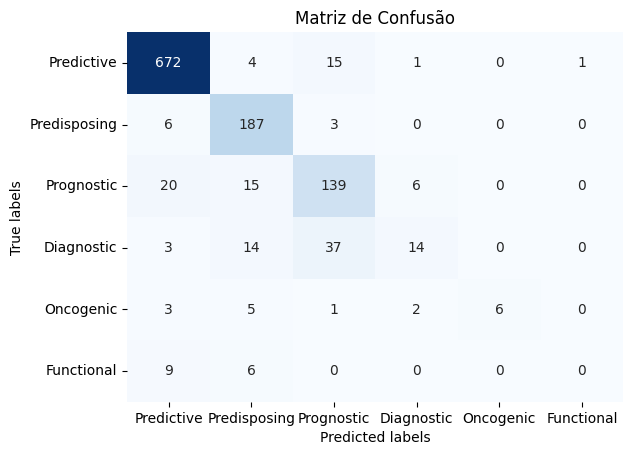

In [57]:
from sklearn.metrics import confusion_matrix
# colocando o modelo no modo de avaliação
model.eval()
# lista para armazenar as previsões do modelo
predicted_labels = []
# lista para armazenar as verdadeiras labels
true_labels = []
# percorre o conjunto de testes e faz as previsões
for data in test_loader:
    inputs, outputs = data
    predicted_outputs = model(inputs)
    _, predicted = torch.max(predicted_outputs.data, 1)
    predicted_labels.append(predicted.item())
    true_labels.append(outputs.item())

# cria a matriz de confusão
cm = confusion_matrix(true_labels, predicted_labels)
# labels para o eixo x e y
labels = list(y.loc[:, 'evidence_type'].value_counts().keys())
# plotando a matriz de confusão
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, cbar=False)
# labels do gráfico
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de Confusão')
plt.show()

Com a Matriz de Confusão é possível visualizar quantos previsões foram corretas através dos valores diagonais e todos os valores fora foram as classificações preditas erroneamente, nossos falsos positivos.

In [56]:
#quantidade de ocorrências para cada categoria
y.value_counts()

evidence_type  evidence_type_num
Predictive     0                    2451
Predisposing   1                     643
Prognostic     2                     511
Diagnostic     3                     194
Oncogenic      4                      67
Functional     5                      31
Name: count, dtype: int64

Observando a distribuição dos tipos de evidência na coluna "evidence_type", podemos notar que os tipos Predictive e Predisposing são os mais frequentes, seguidos pelo tipo Prognostic. Portanto, é natural que o modelo tenha apresentado maior acurácia ao prever esses tipos de evidência.